# Additional tests Thomas

In [145]:
%matplotlib inline
import imp
import numpy as np
import pandas as pd
import os
from math import *
import datetime as dt
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns; sns.set()
from time import time
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import category_encoders as ce
from category_encoders.ordinal import OrdinalEncoder
import category_encoders.utils as util

In [174]:
problem = imp.load_source('', 'problem.py') #import a module with different methods taken from ramp-workflow
X_df, y_array = problem.get_train_data() #get_train_data() is one of these methods

X_train = X_df.copy()
y_train = y_array.copy()

## Feature extractor

In [275]:
class FeatureExtractor(object):
#    def __init__(self):
#        pass

#    def fit(self, X_df, y_array):
#        pass

#    def transform(self, X_df)
    def transform(X_df):
        def haversine(lon1, lat1, lon2, lat2):
            # Function to compute the great circle distance between 2 points on Earth
            
            # a. Convert decimal degrees (latitude & longitude) to radians 
            lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

            # b. Haversine formula
            dlon = lon2 - lon1 
            dlat = lat2 - lat1 
            a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
            c = 2 * asin(sqrt(a)) 
            r = 6371 # Earth radius in kilometers
            return c * r
        
        # 1) Reading data:

        X_encoded = X_df.copy()
        __file__ = 'submissions/starting_kit/'
        path = os.path.dirname(__file__)
        external_data = pd.read_csv(os.path.join(path, 'external_data.csv'))
        
        # 2) Starting with weather data transformation and merging with X_encoded:

        X_weather = external_data[['Date', 'AirPort', 'Mean TemperatureC', 'MeanDew PointC', 
                                         'Mean Humidity', 'Mean Sea Level PressurehPa', 'Mean VisibilityKm',
                                         'Mean Wind SpeedKm/h', 'CloudCover']]
        X_weather = X_weather.rename(columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})

        X_encoded = pd.merge(X_encoded, X_weather, how = 'left',
            left_on = ['DateOfDeparture', 'Arrival'],
            right_on = ['DateOfDeparture', 'Arrival'],
            sort = False)
        
        # 3) Airport data transformation and merging:

        airport_data = external_data[['Date', 'AirPort','Rank_2018','State','city','lat',
                                            'lng','population','density','Fuel_price','Holiday',
                                            'LOAD_FACTOR','2018_freq']]
    
        ## We need to distinguish data related to departure and arrival airports
        Dep_data = airport_data.add_suffix('_Dep')
        Arr_data = airport_data.add_suffix('_Arr')
        
        ## We then merge both departure and arrival information with X_encoded
        X_encoded = pd.merge(X_encoded, Dep_data, how = 'left', 
            left_on = ['DateOfDeparture', 'Departure'],
            right_on = ['Date_Dep', 'AirPort_Dep'],
            sort = False)
        
        X_encoded = pd.merge(X_encoded, Arr_data, how = 'left', 
            left_on = ['DateOfDeparture', 'Arrival'],
            right_on = ['Date_Arr', 'AirPort_Arr'],
            sort = False)
        
        ## Distance calculation
        X_encoded['Distance'] = X_encoded.apply(lambda x: 
            haversine(x['lng_Dep'], x['lat_Dep'], x['lng_Arr'], x['lat_Arr']), axis = 1)

        # 4) Flight route data transformation and merging:
        
        ## Add flight route information in X_encoded
        X_encoded['ROUTE'] = X_encoded[['Departure', 'Arrival']].apply(''.join, axis=1)

        ## Select flight route data in external dataset
        route_data = external_data[['Year_route', 'Quarter_route',
                                          'daily_passengers', 'average_fare', 'ROUTE', 'AIR_TIME_MEAN']]
        
        ## Split date information in X_encoded to help for merging
        X_encoded['Weekend'] = ((pd.DatetimeIndex(X_encoded['DateOfDeparture']).dayofweek) // 
            5 == 1).astype(float)
        X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
        X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
        X_encoded['quarter'] = X_encoded['DateOfDeparture'].dt.quarter
        X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
        X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
        X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
        X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
        X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date:
            (date - pd.to_datetime("1970-01-01")).days)
        
        ## Merge flight route data with X_encoded
        X_encoded = pd.merge(X_encoded, route_data, how = 'left', 
            left_on = ['year','quarter','ROUTE'],
            right_on = ['Year_route','Quarter_route','ROUTE'],
            sort = False)
    
        # 5) One-hot encoding of categorical features (Dep/Arr airports, dates):

        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Departure'], prefix = 'd'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Arrival'], prefix = 'a'))
           
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['day'], prefix='d'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['weekday'], prefix='wd'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['week'], prefix='w'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['quarter'], prefix='q'))

        X_encoded['Rank_2018_Arr'] = X_encoded['Rank_2018_Arr'].astype(int)
        X_encoded['Rank_2018_Dep'] = X_encoded['Rank_2018_Dep'].astype(int)
        
        # 5) Final feature selection
        ## We drop one-hot encoded features and irrelevant features (based on feature importance analysis)
        
        X_encoded = X_encoded.drop(['DateOfDeparture','Departure','Arrival','Quarter_route',
                                    'Date_Dep','Date_Arr','city_Dep','city_Arr','AirPort_Dep',
                                    'State_Dep', 'AirPort_Arr', 'State_Arr','Fuel_price_Arr',
                                    'Holiday_Arr','year','month','week','day','weekday','lat_Dep',
                                    'lng_Dep','lat_Arr','lng_Arr','ROUTE','std_wtd','Year_route',
                                    'LOAD_FACTOR_Arr','Mean Sea Level PressurehPa','MeanDew PointC',
                                    'Mean Wind SpeedKm/h','Mean VisibilityKm', 'quarter',
                                    'w_32', 'w_18', 'w_33', 'w_19', 'w_31', 'w_24', 'd_21', 'd_16', 'w_28',
                                    'w_12', 'd_26', 'd_14', 'w_40', 'a_IAH', 'w_43', 'd_6', 'w_16', 'w_11',
                                    'w_17', 'd_22', 'w_30', 'w_29', 'd_19', 'd_17', 'w_23', 'd_SEA',
                                    'a_PHL', 'd_MSP', 'w_45', 'd_DEN', 'w_34', 'd_DFW', 'CloudCover',
                                    'a_SEA', 'w_13', 'Mean Humidity', 'd_20', 'd_11', 'w_25', 'd_15',
                                    'd_13', 'w_15', 'w_42', 'a_ATL', 'd_24', 'w_48', 'w_39',
                                    'y_2012', 'm_7', 'm_2', 'q_4'], axis=1)
        return X_encoded

In [276]:
X_train = X_df.copy()
X_train = FeatureExtractor.transform(X_train)
X_train.shape

(8902, 119)

## Regressor

In [277]:
class Regressor(BaseEstimator):
# To optimize performance we chose the XGBoost model and selected parmeters with GridSearch

    def __init__(self):
        self.reg = xgb.XGBRegressor(colsample_bytree = 0.7, learning_rate = 0.05, 
                                    max_depth = 10, min_child_weight = 4, n_estimators = 5000, nthread = 4, 
                                    objective = 'reg:linear', silent = 1, subsample = 0.7)
    def fit(self, X, y):
        self.reg.fit(X, y)      

    def predict(self, X):
        return self.reg.predict(X)

In [278]:
XGB = xgb.XGBRegressor(colsample_bytree = 0.7, learning_rate = 0.05, 
                                    max_depth = 7, min_child_weight = 4, n_estimators = 5000, nthread = 4, 
                                    objective = 'reg:linear', silent = 1, subsample = 0.7)
XGB.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=4, missing=None, n_estimators=5000,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.7, verbosity=1)

In [279]:
y_pred_train = XGB.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

train rmse:  0.0005901212946589573


In [280]:
X_test_df, y_test_array = problem.get_test_data()
X_test = FeatureExtractor.transform(X_test_df)
y_pred = XGB.predict(X_test)
score_type = problem.score_types[0]
print("test rms e: ", score_type(y_test_array, y_pred))

test rms e:  0.3283142065223776


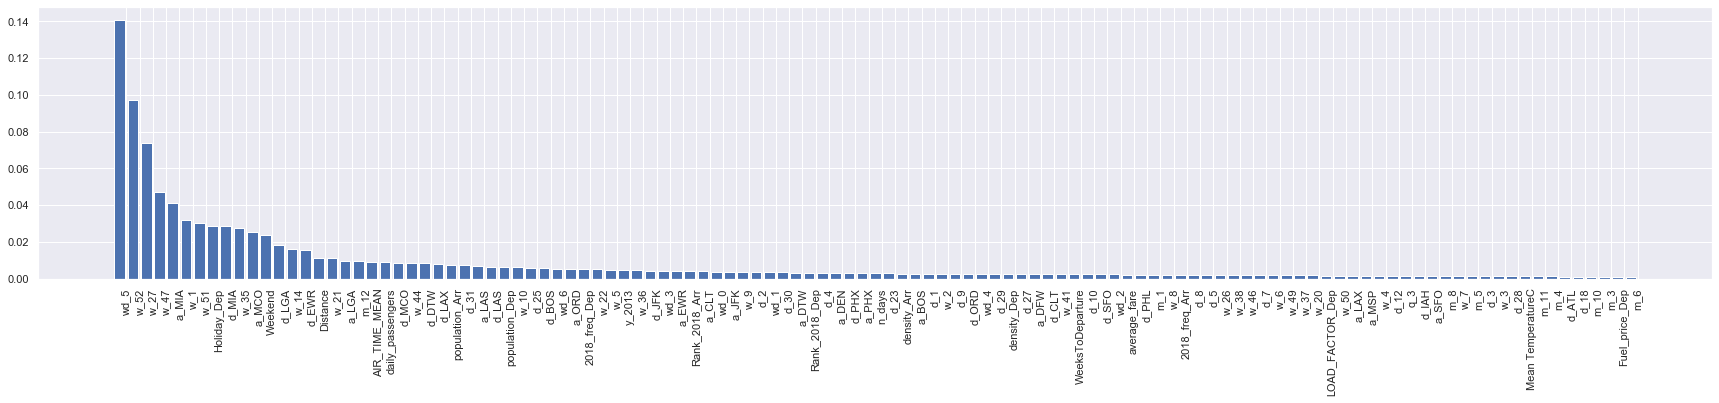

In [274]:
# plots showing how important each column is in the prediction
X_columns = X_train.columns
plt.figure(figsize=(30, 5))

ordering = np.argsort(XGB.feature_importances_)[::-1]

importances = XGB.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90);

In [268]:
feature_names[::-1][:20]

Index(['Fuel_price_Dep', 'q_2', 'm_9', 'y_2011', 'q_1', 'm_5', 'm_4', 'm_11',
       'd_IAH', 'q_3', 'Mean TemperatureC', 'm_3', 'm_10', 'm_8', 'd_28',
       'w_3', 'w_6', 'd_18', 'm_6', 'w_49'],
      dtype='object')

### Different models

In [185]:
# Gradient Boosting
GB = GradientBoostingRegressor(n_estimators=50000,
            learning_rate=0.05, max_depth=10, max_features='sqrt',
            min_samples_leaf=50, min_samples_split=10, loss='huber')
GB.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
y_pred_train = XGB.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

In [ ]:
X_test_df, y_test_array = problem.get_test_data()
X_test = FeatureExtractor.transform(X_test_df)
y_pred = XGB.predict(X_test)
score_type = problem.score_types[0]
print("test rmse: ", score_type(y_test_array, y_pred))

In [ ]:
# plots showing how important each column is in the prediction
X_columns = X_train.columns
plt.figure(figsize=(15, 5))

ordering = np.argsort(XGB.feature_importances_)[::-1][:100]

importances = XGB.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=9)

## External data corrections

In [65]:
external = pd.read_csv('/Users/Thomas/Documents/Data Science X/Cours/Python/RAMP Project/air_passengers_project-master/submissions/starting_kit/external_data.csv')
external

,Unnamed: 0,Date,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,Rank_2018,State,2018,2017,2016,2015,city,lat,lng,population,density,ranking,Fuel_price,Holiday,Month,Year,Quarter,LOAD_FACTOR
0,0,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129,1,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,1,3088,0,9,2011,3,81.82
1,1,2011-09-01,ORD,34,28,22,23,22,19,84,70,56,1015,1013,1011,16,15,11,26,9,37.0,0.00,1,NaN,197,3,IL,39874879,38593028,37589899,36305668,Chicago,41.8373,-87.6862,8675982.0,4612.0,1,3088,0,9,2011,3,81.82
2,2,2011-09-01,LAX,21,18,15,14,14,13,90,76,61,1012,1011,1009,16,11,4,23,13,NaN,0.00,5,Fog,265,2,CA,42626783,41232432,39636042,36351226,Los Angeles,34.1139,-118.4068,12815475.0,3295.0,1,3088,0,9,2011,3,81.82
3,3,2011-09-01,DFW,38,33,27,17,14,11,51,35,19,1015,1013,1010,16,16,16,34,14,45.0,0.00,1,NaN,157,4,TX,32800721,31816933,31283579,31589832,Dallas,32.7936,-96.7662,5733259.0,1524.0,1,3088,0,9,2011,3,81.82
4,4,2011-09-01,DEN,36,28,20,5,3,-2,34,22,9,1016,1007,1004,16,16,16,29,15,39.0,0.00,5,NaN,205,5,CO,31363573,29809097,28267394,26280043,Denver,39.7621,-104.8759,2787266.0,1774.0,1,3088,0,9,2011,3,81.82
5,5,2011-09-01,JFK,27,23,19,18,16,12,87,65,42,1023,1022,1020,16,16,16,24,9,29.0,0.00,5,NaN,169,6,NY,30541459,29533154,29239151,27782369,New York,40.6943,-73.9249,19354922.0,11083.0,1,3088,0,9,2011,3,81.82
6,6,2011-09-01,SFO,22,17,12,13,11,9,83,69,55,1012,1010,1008,16,16,16,39,15,45.0,0.00,3,NaN,276,7,CA,27794154,26900048,25707101,24190549,San Francisco,37.7562,-122.4430,3603761.0,7286.0,1,3088,0,9,2011,3,81.82
7,7,2011-09-01,CLT,33,26,17,19,18,16,93,66,38,1022,1020,1017,16,16,11,21,5,24.0,0.00,2,NaN,315,12,NC,22283574,22011251,21511880,21913166,Charlotte,35.2079,-80.8304,1467362.0,1081.0,1,3088,0,9,2011,3,81.82
8,8,2011-09-01,LAS,39,33,26,-12,-16,-27,7,4,1,1008,1005,1003,16,16,16,39,24,48.0,0.00,0,NaN,206,9,NV,23655285,23364393,22833267,21824231,Las Vegas,36.2333,-115.2654,2073045.0,1747.0,1,3088,0,9,2011,3,81.82
9,9,2011-09-01,PHX,44,38,32,14,10,2,34,23,11,1008,1004,1001,16,16,16,24,11,34.0,0.00,3,NaN,154,13,AZ,21623842,21185458,20896265,21351445,Phoenix,33.5722,-112.0891,4081849.0,1212.0,1,3088,0,9,2011,3,81.82


In [66]:
external.drop(['ranking','Unnamed: 0', 'Max TemperatureC', 'Min TemperatureC', 'Dew PointC','Min DewpointC','Max Humidity','Min Humidity','Max Sea Level PressurehPa','Min Sea Level PressurehPa','Max VisibilityKm','Min VisibilitykM','Max Wind SpeedKm/h','Max Gust SpeedKm/h','Events','WindDirDegrees'], axis=1, inplace=True)
external

,Date,AirPort,Mean TemperatureC,MeanDew PointC,Mean Humidity,Mean Sea Level PressurehPa,Mean VisibilityKm,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,Rank_2018,State,2018,2017,2016,2015,city,lat,lng,population,density,Fuel_price,Holiday,Month,Year,Quarter,LOAD_FACTOR
0,2011-09-01,ATL,29,18,56,1019,16,6,0.00,3,1,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,3088,0,9,2011,3,81.82
1,2011-09-01,ORD,28,22,70,1013,15,9,0.00,1,3,IL,39874879,38593028,37589899,36305668,Chicago,41.8373,-87.6862,8675982.0,4612.0,3088,0,9,2011,3,81.82
2,2011-09-01,LAX,18,14,76,1011,11,13,0.00,5,2,CA,42626783,41232432,39636042,36351226,Los Angeles,34.1139,-118.4068,12815475.0,3295.0,3088,0,9,2011,3,81.82
3,2011-09-01,DFW,33,14,35,1013,16,14,0.00,1,4,TX,32800721,31816933,31283579,31589832,Dallas,32.7936,-96.7662,5733259.0,1524.0,3088,0,9,2011,3,81.82
4,2011-09-01,DEN,28,3,22,1007,16,15,0.00,5,5,CO,31363573,29809097,28267394,26280043,Denver,39.7621,-104.8759,2787266.0,1774.0,3088,0,9,2011,3,81.82
5,2011-09-01,JFK,23,16,65,1022,16,9,0.00,5,6,NY,30541459,29533154,29239151,27782369,New York,40.6943,-73.9249,19354922.0,11083.0,3088,0,9,2011,3,81.82
6,2011-09-01,SFO,17,11,69,1010,16,15,0.00,3,7,CA,27794154,26900048,25707101,24190549,San Francisco,37.7562,-122.4430,3603761.0,7286.0,3088,0,9,2011,3,81.82
7,2011-09-01,CLT,26,18,66,1020,16,5,0.00,2,12,NC,22283574,22011251,21511880,21913166,Charlotte,35.2079,-80.8304,1467362.0,1081.0,3088,0,9,2011,3,81.82
8,2011-09-01,LAS,33,-16,4,1005,16,24,0.00,0,9,NV,23655285,23364393,22833267,21824231,Las Vegas,36.2333,-115.2654,2073045.0,1747.0,3088,0,9,2011,3,81.82
9,2011-09-01,PHX,38,10,23,1004,16,11,0.00,3,13,AZ,21623842,21185458,20896265,21351445,Phoenix,33.5722,-112.0891,4081849.0,1212.0,3088,0,9,2011,3,81.82


In [67]:
external.rename(columns={'2018':'2018_freq','2017':'2017_freq','2016':'2016_freq','2015':'2015_freq'},inplace=True)
external

,Date,AirPort,Mean TemperatureC,MeanDew PointC,Mean Humidity,Mean Sea Level PressurehPa,Mean VisibilityKm,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,Rank_2018,State,2018_freq,2017_freq,2016_freq,2015_freq,city,lat,lng,population,density,Fuel_price,Holiday,Month,Year,Quarter,LOAD_FACTOR
0,2011-09-01,ATL,29,18,56,1019,16,6,0.00,3,1,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,3088,0,9,2011,3,81.82
1,2011-09-01,ORD,28,22,70,1013,15,9,0.00,1,3,IL,39874879,38593028,37589899,36305668,Chicago,41.8373,-87.6862,8675982.0,4612.0,3088,0,9,2011,3,81.82
2,2011-09-01,LAX,18,14,76,1011,11,13,0.00,5,2,CA,42626783,41232432,39636042,36351226,Los Angeles,34.1139,-118.4068,12815475.0,3295.0,3088,0,9,2011,3,81.82
3,2011-09-01,DFW,33,14,35,1013,16,14,0.00,1,4,TX,32800721,31816933,31283579,31589832,Dallas,32.7936,-96.7662,5733259.0,1524.0,3088,0,9,2011,3,81.82
4,2011-09-01,DEN,28,3,22,1007,16,15,0.00,5,5,CO,31363573,29809097,28267394,26280043,Denver,39.7621,-104.8759,2787266.0,1774.0,3088,0,9,2011,3,81.82
5,2011-09-01,JFK,23,16,65,1022,16,9,0.00,5,6,NY,30541459,29533154,29239151,27782369,New York,40.6943,-73.9249,19354922.0,11083.0,3088,0,9,2011,3,81.82
6,2011-09-01,SFO,17,11,69,1010,16,15,0.00,3,7,CA,27794154,26900048,25707101,24190549,San Francisco,37.7562,-122.4430,3603761.0,7286.0,3088,0,9,2011,3,81.82
7,2011-09-01,CLT,26,18,66,1020,16,5,0.00,2,12,NC,22283574,22011251,21511880,21913166,Charlotte,35.2079,-80.8304,1467362.0,1081.0,3088,0,9,2011,3,81.82
8,2011-09-01,LAS,33,-16,4,1005,16,24,0.00,0,9,NV,23655285,23364393,22833267,21824231,Las Vegas,36.2333,-115.2654,2073045.0,1747.0,3088,0,9,2011,3,81.82
9,2011-09-01,PHX,38,10,23,1004,16,11,0.00,3,13,AZ,21623842,21185458,20896265,21351445,Phoenix,33.5722,-112.0891,4081849.0,1212.0,3088,0,9,2011,3,81.82


In [69]:
external['Fuel_price'] = external['Fuel_price'].astype(str)
external.dtypes

Date                           object
AirPort                        object
Mean TemperatureC               int64
MeanDew PointC                  int64
Mean Humidity                   int64
Mean Sea Level PressurehPa      int64
Mean VisibilityKm               int64
Mean Wind SpeedKm/h             int64
Precipitationmm                object
CloudCover                      int64
Rank_2018                      object
State                          object
2018_freq                       int64
2017_freq                       int64
2016_freq                       int64
2015_freq                       int64
city                           object
lat                           float64
lng                           float64
population                    float64
density                       float64
Fuel_price                     object
Holiday                         int64
Month                           int64
Year                            int64
Quarter                         int64
LOAD_FACTOR 

In [72]:
for i in range(len(external['Fuel_price'])):
    if len(external.loc[i, "Fuel_price"])==2:
           external.loc[i, "Fuel_price"]=external.loc[i, "Fuel_price"]+'00'
    elif len(external.loc[i, "Fuel_price"])==3:
           external.loc[i, "Fuel_price"]=external.loc[i, "Fuel_price"]+'0'
    elif len(external.loc[i, "Fuel_price"])==1:
           external.loc[i, "Fuel_price"]=external.loc[i, "Fuel_price"]+'000'

In [73]:
external['Fuel_price'] = external['Fuel_price'].astype(int)

In [74]:
external['Fuel_price'] = external['Fuel_price']/1000
external['Fuel_price'].unique()

array([3.088, 3.038, 3.043, 3.05 , 3.018, 2.962, 2.938, 2.922, 2.937,
       3.019, 3.002, 2.946, 2.919, 2.853, 2.827, 2.86 , 2.928, 2.877,
       2.894, 2.844, 2.815, 2.838, 2.835, 2.916, 2.881, 2.911, 2.889,
       2.917, 2.972, 3.056, 2.986, 3.01 , 2.982, 3.028, 3.036, 3.025,
       3.006, 3.051, 3.011, 2.991, 3.067, 3.114, 3.119, 3.095, 3.131,
       3.178, 3.158, 3.156, 3.086, 3.052, 2.964, 3.005, 2.936, 2.914,
       2.939, 3.001, 2.969, 2.968, 2.941, 2.977, 2.943, 2.867, 2.841,
       2.824, 2.854, 2.761, 2.749, 2.768, 2.739, 2.829, 2.874, 2.91 ,
       2.885, 2.891, 2.93 , 2.984, 3.04 , 3.1  , 3.06 , 3.102, 3.134,
       3.168, 3.136, 3.079, 3.076, 3.093, 3.045, 3.055, 3.07 , 3.062,
       3.082, 3.068, 3.085, 3.217, 3.212, 3.197, 3.216, 3.17 , 3.15 ,
       3.165, 3.191, 3.215, 3.237, 3.29 , 3.313, 3.33 , 3.294, 3.239,
       3.273, 3.205, 3.22 , 3.204, 3.236, 3.288, 3.278, 3.298, 3.292,
       3.246, 3.309, 3.272, 3.263, 3.235, 3.203, 3.269, 3.262, 3.275,
       3.228, 3.242,

In [75]:
external

,Date,AirPort,Mean TemperatureC,MeanDew PointC,Mean Humidity,Mean Sea Level PressurehPa,Mean VisibilityKm,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,Rank_2018,State,2018_freq,2017_freq,2016_freq,2015_freq,city,lat,lng,population,density,Fuel_price,Holiday,Month,Year,Quarter,LOAD_FACTOR
0,2011-09-01,ATL,29,18,56,1019,16,6,0.00,3,1,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,3.088,0,9,2011,3,81.82
1,2011-09-01,ORD,28,22,70,1013,15,9,0.00,1,3,IL,39874879,38593028,37589899,36305668,Chicago,41.8373,-87.6862,8675982.0,4612.0,3.088,0,9,2011,3,81.82
2,2011-09-01,LAX,18,14,76,1011,11,13,0.00,5,2,CA,42626783,41232432,39636042,36351226,Los Angeles,34.1139,-118.4068,12815475.0,3295.0,3.088,0,9,2011,3,81.82
3,2011-09-01,DFW,33,14,35,1013,16,14,0.00,1,4,TX,32800721,31816933,31283579,31589832,Dallas,32.7936,-96.7662,5733259.0,1524.0,3.088,0,9,2011,3,81.82
4,2011-09-01,DEN,28,3,22,1007,16,15,0.00,5,5,CO,31363573,29809097,28267394,26280043,Denver,39.7621,-104.8759,2787266.0,1774.0,3.088,0,9,2011,3,81.82
5,2011-09-01,JFK,23,16,65,1022,16,9,0.00,5,6,NY,30541459,29533154,29239151,27782369,New York,40.6943,-73.9249,19354922.0,11083.0,3.088,0,9,2011,3,81.82
6,2011-09-01,SFO,17,11,69,1010,16,15,0.00,3,7,CA,27794154,26900048,25707101,24190549,San Francisco,37.7562,-122.4430,3603761.0,7286.0,3.088,0,9,2011,3,81.82
7,2011-09-01,CLT,26,18,66,1020,16,5,0.00,2,12,NC,22283574,22011251,21511880,21913166,Charlotte,35.2079,-80.8304,1467362.0,1081.0,3.088,0,9,2011,3,81.82
8,2011-09-01,LAS,33,-16,4,1005,16,24,0.00,0,9,NV,23655285,23364393,22833267,21824231,Las Vegas,36.2333,-115.2654,2073045.0,1747.0,3.088,0,9,2011,3,81.82
9,2011-09-01,PHX,38,10,23,1004,16,11,0.00,3,13,AZ,21623842,21185458,20896265,21351445,Phoenix,33.5722,-112.0891,4081849.0,1212.0,3.088,0,9,2011,3,81.82


In [77]:
external.to_csv('/Users/Thomas/Documents/Data Science X/Cours/Python/RAMP Project/air_passengers_project-master/submissions/starting_kit/external_data.csv')

### Create routes in airtimes and fares

In [80]:
airtimes=pd.read_csv('/Users/Thomas/Documents/Data Science X/Cours/Python/RAMP Project/air_passengers_project-master/data/airtimes.csv')
airtimes.drop(['Unnamed: 0', 'ORIGIN_CITY_NAME','DEST_CITY_NAME'], axis = 1, inplace = True)
airtimes

,ORIGIN,DEST,AIR_TIME_MEAN
0,ATL,ATL,45.00
1,ATL,BOS,6002.21
2,ATL,CLT,1481.41
3,ATL,DEN,7305.19
4,ATL,DFW,8133.17
5,ATL,DTW,2285.96
6,ATL,EWR,3795.96
7,ATL,IAH,3210.57
8,ATL,JFK,2409.05
9,ATL,LAS,15257.25


In [81]:
airtimes['ROUTE'] = airtimes[['ORIGIN', 'DEST']].apply(''.join, axis=1)
airtimes

,ORIGIN,DEST,AIR_TIME_MEAN,ROUTE
0,ATL,ATL,45.00,ATLATL
1,ATL,BOS,6002.21,ATLBOS
2,ATL,CLT,1481.41,ATLCLT
3,ATL,DEN,7305.19,ATLDEN
4,ATL,DFW,8133.17,ATLDFW
5,ATL,DTW,2285.96,ATLDTW
6,ATL,EWR,3795.96,ATLEWR
7,ATL,IAH,3210.57,ATLIAH
8,ATL,JFK,2409.05,ATLJFK
9,ATL,LAS,15257.25,ATLLAS


In [114]:
fares=pd.read_csv('/Users/Thomas/Documents/Data Science X/Cours/Python/RAMP Project/air_passengers_project-master/data/fares.csv')
fares.drop(['Unnamed: 0', 'Departure','Arrival'], axis = 1, inplace = True)
fares1 = fares
fares1['ROUTE'] = fares1[['DEP', 'ARR']].apply(''.join, axis=1)
fares1

,Year,quarter,miles_distance,daily_passengers,average_fare,DEP,ARR,ROUTE
0,2011,3,952,2335,208.31,ATL,BOS,ATLBOS
1,2011,4,952,2117,227.89,ATL,BOS,ATLBOS
2,2012,1,952,1704,235.04,ATL,BOS,ATLBOS
3,2012,2,952,2335,226.73,ATL,BOS,ATLBOS
4,2012,3,952,2437,196.87,ATL,BOS,ATLBOS
5,2012,4,952,2255,203.29,ATL,BOS,ATLBOS
6,2013,1,952,1784,212.29,ATL,BOS,ATLBOS
7,2013,2,952,2477,216.50,ATL,BOS,ATLBOS
8,2011,3,226,381,171.73,ATL,CLT,ATLCLT
9,2011,4,226,370,165.83,ATL,CLT,ATLCLT


In [115]:
fares2=fares.copy()
fares2['ROUTE'] = fares2[['ARR', 'DEP']].apply(''.join, axis=1)
fares2

,Year,quarter,miles_distance,daily_passengers,average_fare,DEP,ARR,ROUTE
0,2011,3,952,2335,208.31,ATL,BOS,BOSATL
1,2011,4,952,2117,227.89,ATL,BOS,BOSATL
2,2012,1,952,1704,235.04,ATL,BOS,BOSATL
3,2012,2,952,2335,226.73,ATL,BOS,BOSATL
4,2012,3,952,2437,196.87,ATL,BOS,BOSATL
5,2012,4,952,2255,203.29,ATL,BOS,BOSATL
6,2013,1,952,1784,212.29,ATL,BOS,BOSATL
7,2013,2,952,2477,216.50,ATL,BOS,BOSATL
8,2011,3,226,381,171.73,ATL,CLT,CLTATL
9,2011,4,226,370,165.83,ATL,CLT,CLTATL


In [116]:
fares3 = [fares1, fares2]
fares3

[      Year  quarter  miles_distance  daily_passengers  average_fare  DEP  ARR  \
 0     2011        3             952              2335        208.31  ATL  BOS   
 1     2011        4             952              2117        227.89  ATL  BOS   
 2     2012        1             952              1704        235.04  ATL  BOS   
 3     2012        2             952              2335        226.73  ATL  BOS   
 4     2012        3             952              2437        196.87  ATL  BOS   
 5     2012        4             952              2255        203.29  ATL  BOS   
 6     2013        1             952              1784        212.29  ATL  BOS   
 7     2013        2             952              2477        216.50  ATL  BOS   
 8     2011        3             226               381        171.73  ATL  CLT   
 9     2011        4             226               370        165.83  ATL  CLT   
 10    2012        1             226               399        176.71  ATL  CLT   
 11    2012     

In [117]:
fares3 = pd.concat(fares3)
fares3

,Year,quarter,miles_distance,daily_passengers,average_fare,DEP,ARR,ROUTE
0,2011,3,952,2335,208.31,ATL,BOS,ATLBOS
1,2011,4,952,2117,227.89,ATL,BOS,ATLBOS
2,2012,1,952,1704,235.04,ATL,BOS,ATLBOS
3,2012,2,952,2335,226.73,ATL,BOS,ATLBOS
4,2012,3,952,2437,196.87,ATL,BOS,ATLBOS
5,2012,4,952,2255,203.29,ATL,BOS,ATLBOS
6,2013,1,952,1784,212.29,ATL,BOS,ATLBOS
7,2013,2,952,2477,216.50,ATL,BOS,ATLBOS
8,2011,3,226,381,171.73,ATL,CLT,ATLCLT
9,2011,4,226,370,165.83,ATL,CLT,ATLCLT


In [119]:
fares = fares3.drop(fares3[(fares3['Year'] == 2013) & (fares3['quarter'] == 2)].index)

In [120]:
fares.reset_index(drop=True, inplace=True)
fares

,Year,quarter,miles_distance,daily_passengers,average_fare,DEP,ARR,ROUTE
0,2011,3,952,2335,208.31,ATL,BOS,ATLBOS
1,2011,4,952,2117,227.89,ATL,BOS,ATLBOS
2,2012,1,952,1704,235.04,ATL,BOS,ATLBOS
3,2012,2,952,2335,226.73,ATL,BOS,ATLBOS
4,2012,3,952,2437,196.87,ATL,BOS,ATLBOS
5,2012,4,952,2255,203.29,ATL,BOS,ATLBOS
6,2013,1,952,1784,212.29,ATL,BOS,ATLBOS
7,2011,3,226,381,171.73,ATL,CLT,ATLCLT
8,2011,4,226,370,165.83,ATL,CLT,ATLCLT
9,2012,1,226,399,176.71,ATL,CLT,ATLCLT


In [89]:
airtimes.to_csv('/Users/Thomas/Documents/Data Science X/Cours/Python/RAMP Project/air_passengers_project-master/data/air_times.csv')

In [121]:
fares.to_csv('/Users/Thomas/Documents/Data Science X/Cours/Python/RAMP Project/air_passengers_project-master/data/fares_pass.csv')

### Create a route dataset

In [122]:
routes = pd.merge(fares, airtimes, how = 'left', 
            left_on = ['ROUTE'],
            right_on = ['ROUTE'],
            sort = False)
routes

,Year,quarter,miles_distance,daily_passengers,average_fare,DEP,ARR,ROUTE,ORIGIN,DEST,AIR_TIME_MEAN
0,2011,3,952,2335,208.31,ATL,BOS,ATLBOS,ATL,BOS,6002.21
1,2011,4,952,2117,227.89,ATL,BOS,ATLBOS,ATL,BOS,6002.21
2,2012,1,952,1704,235.04,ATL,BOS,ATLBOS,ATL,BOS,6002.21
3,2012,2,952,2335,226.73,ATL,BOS,ATLBOS,ATL,BOS,6002.21
4,2012,3,952,2437,196.87,ATL,BOS,ATLBOS,ATL,BOS,6002.21
5,2012,4,952,2255,203.29,ATL,BOS,ATLBOS,ATL,BOS,6002.21
6,2013,1,952,1784,212.29,ATL,BOS,ATLBOS,ATL,BOS,6002.21
7,2011,3,226,381,171.73,ATL,CLT,ATLCLT,ATL,CLT,1481.41
8,2011,4,226,370,165.83,ATL,CLT,ATLCLT,ATL,CLT,1481.41
9,2012,1,226,399,176.71,ATL,CLT,ATLCLT,ATL,CLT,1481.41


In [123]:
routes.iloc[1288]

Year                   2011
quarter                   3
miles_distance          952
daily_passengers       2335
average_fare         208.31
DEP                     ATL
ARR                     BOS
ROUTE                BOSATL
ORIGIN                  BOS
DEST                    ATL
AIR_TIME_MEAN       6537.53
Name: 1288, dtype: object

In [124]:
routes.drop(['DEP','ARR','ORIGIN','DEST'], axis=1, inplace=True)

In [127]:
routes.rename(columns={'Year':'Year_route','quarter':'Quarter_route'}, inplace=True)
routes

,Year_route,Quarter_route,miles_distance,daily_passengers,average_fare,ROUTE,AIR_TIME_MEAN
0,2011,3,952,2335,208.31,ATLBOS,6002.21
1,2011,4,952,2117,227.89,ATLBOS,6002.21
2,2012,1,952,1704,235.04,ATLBOS,6002.21
3,2012,2,952,2335,226.73,ATLBOS,6002.21
4,2012,3,952,2437,196.87,ATLBOS,6002.21
5,2012,4,952,2255,203.29,ATLBOS,6002.21
6,2013,1,952,1784,212.29,ATLBOS,6002.21
7,2011,3,226,381,171.73,ATLCLT,1481.41
8,2011,4,226,370,165.83,ATLCLT,1481.41
9,2012,1,226,399,176.71,ATLCLT,1481.41


In [128]:
routes.to_csv('/Users/Thomas/Documents/Data Science X/Cours/Python/RAMP Project/air_passengers_project-master/data/route_data.csv')

### Concatenate with external_data

In [129]:
external_large = pd.concat([external, routes], axis=1)
external_large

,Date,AirPort,Mean TemperatureC,MeanDew PointC,Mean Humidity,Mean Sea Level PressurehPa,Mean VisibilityKm,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,Rank_2018,State,2018_freq,2017_freq,2016_freq,2015_freq,city,lat,lng,population,density,Fuel_price,Holiday,Month,Year,Quarter,LOAD_FACTOR,Year_route,Quarter_route,miles_distance,daily_passengers,average_fare,ROUTE,AIR_TIME_MEAN
0,2011-09-01,ATL,29,18,56,1019,16,6,0.00,3,1,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,3.088,0,9,2011,3,81.82,2011.0,3.0,952.0,2335.0,208.31,ATLBOS,6002.21
1,2011-09-01,ORD,28,22,70,1013,15,9,0.00,1,3,IL,39874879,38593028,37589899,36305668,Chicago,41.8373,-87.6862,8675982.0,4612.0,3.088,0,9,2011,3,81.82,2011.0,4.0,952.0,2117.0,227.89,ATLBOS,6002.21
2,2011-09-01,LAX,18,14,76,1011,11,13,0.00,5,2,CA,42626783,41232432,39636042,36351226,Los Angeles,34.1139,-118.4068,12815475.0,3295.0,3.088,0,9,2011,3,81.82,2012.0,1.0,952.0,1704.0,235.04,ATLBOS,6002.21
3,2011-09-01,DFW,33,14,35,1013,16,14,0.00,1,4,TX,32800721,31816933,31283579,31589832,Dallas,32.7936,-96.7662,5733259.0,1524.0,3.088,0,9,2011,3,81.82,2012.0,2.0,952.0,2335.0,226.73,ATLBOS,6002.21
4,2011-09-01,DEN,28,3,22,1007,16,15,0.00,5,5,CO,31363573,29809097,28267394,26280043,Denver,39.7621,-104.8759,2787266.0,1774.0,3.088,0,9,2011,3,81.82,2012.0,3.0,952.0,2437.0,196.87,ATLBOS,6002.21
5,2011-09-01,JFK,23,16,65,1022,16,9,0.00,5,6,NY,30541459,29533154,29239151,27782369,New York,40.6943,-73.9249,19354922.0,11083.0,3.088,0,9,2011,3,81.82,2012.0,4.0,952.0,2255.0,203.29,ATLBOS,6002.21
6,2011-09-01,SFO,17,11,69,1010,16,15,0.00,3,7,CA,27794154,26900048,25707101,24190549,San Francisco,37.7562,-122.4430,3603761.0,7286.0,3.088,0,9,2011,3,81.82,2013.0,1.0,952.0,1784.0,212.29,ATLBOS,6002.21
7,2011-09-01,CLT,26,18,66,1020,16,5,0.00,2,12,NC,22283574,22011251,21511880,21913166,Charlotte,35.2079,-80.8304,1467362.0,1081.0,3.088,0,9,2011,3,81.82,2011.0,3.0,226.0,381.0,171.73,ATLCLT,1481.41
8,2011-09-01,LAS,33,-16,4,1005,16,24,0.00,0,9,NV,23655285,23364393,22833267,21824231,Las Vegas,36.2333,-115.2654,2073045.0,1747.0,3.088,0,9,2011,3,81.82,2011.0,4.0,226.0,370.0,165.83,ATLCLT,1481.41
9,2011-09-01,PHX,38,10,23,1004,16,11,0.00,3,13,AZ,21623842,21185458,20896265,21351445,Phoenix,33.5722,-112.0891,4081849.0,1212.0,3.088,0,9,2011,3,81.82,2012.0,1.0,226.0,399.0,176.71,ATLCLT,1481.41


In [130]:
external_large.to_csv('/Users/Thomas/Documents/Data Science X/Cours/Python/RAMP Project/air_passengers_project-master/submissions/starting_kit/external_data_large.csv')

In [132]:
external_large.columns

Index(['Date', 'AirPort', 'Mean TemperatureC', 'MeanDew PointC',
       'Mean Humidity', 'Mean Sea Level PressurehPa', 'Mean VisibilityKm',
       'Mean Wind SpeedKm/h', 'Precipitationmm', 'CloudCover', 'Rank_2018',
       'State', '2018_freq', '2017_freq', '2016_freq', '2015_freq', 'city',
       'lat', 'lng', 'population', 'density', 'Fuel_price', 'Holiday', 'Month',
       'Year', 'Quarter', 'LOAD_FACTOR', 'Year_route', 'Quarter_route',
       'miles_distance', 'daily_passengers', 'average_fare', 'ROUTE',
       'AIR_TIME_MEAN'],
      dtype='object')

In [212]:
final_external = pd.read_csv('/Users/Thomas/Documents/Data Science X/Cours/Python/RAMP Project/air_passengers_project-master/submissions/starting_kit/external_data.csv')
final_external

,Unnamed: 0,Unnamed: 0.1,Date,AirPort,Mean TemperatureC,MeanDew PointC,Mean Humidity,Mean Sea Level PressurehPa,Mean VisibilityKm,Mean Wind SpeedKm/h,CloudCover,Rank_2018,State,2018_freq,city,lat,lng,population,density,Fuel_price,Holiday,Month,Year,Quarter,LOAD_FACTOR,Year_route,Quarter_route,daily_passengers,average_fare,ROUTE,AIR_TIME_MEAN
0,0,0,2011-09-01,ATL,29,18,56,1019,16,6,3,1,GA,51866464,Atlanta,33.7627,-84.4225,5228750.0,1384.0,3.088,0,9,2011,3,81.82,2011.0,3.0,2335.0,208.31,ATLBOS,6002.21
1,1,1,2011-09-01,ORD,28,22,70,1013,15,9,1,3,IL,39874879,Chicago,41.8373,-87.6862,8675982.0,4612.0,3.088,0,9,2011,3,81.82,2011.0,4.0,2117.0,227.89,ATLBOS,6002.21
2,2,2,2011-09-01,LAX,18,14,76,1011,11,13,5,2,CA,42626783,Los Angeles,34.1139,-118.4068,12815475.0,3295.0,3.088,0,9,2011,3,81.82,2012.0,1.0,1704.0,235.04,ATLBOS,6002.21
3,3,3,2011-09-01,DFW,33,14,35,1013,16,14,1,4,TX,32800721,Dallas,32.7936,-96.7662,5733259.0,1524.0,3.088,0,9,2011,3,81.82,2012.0,2.0,2335.0,226.73,ATLBOS,6002.21
4,4,4,2011-09-01,DEN,28,3,22,1007,16,15,5,5,CO,31363573,Denver,39.7621,-104.8759,2787266.0,1774.0,3.088,0,9,2011,3,81.82,2012.0,3.0,2437.0,196.87,ATLBOS,6002.21
5,5,5,2011-09-01,JFK,23,16,65,1022,16,9,5,6,NY,30541459,New York,40.6943,-73.9249,19354922.0,11083.0,3.088,0,9,2011,3,81.82,2012.0,4.0,2255.0,203.29,ATLBOS,6002.21
6,6,6,2011-09-01,SFO,17,11,69,1010,16,15,3,7,CA,27794154,San Francisco,37.7562,-122.4430,3603761.0,7286.0,3.088,0,9,2011,3,81.82,2013.0,1.0,1784.0,212.29,ATLBOS,6002.21
7,7,7,2011-09-01,CLT,26,18,66,1020,16,5,2,12,NC,22283574,Charlotte,35.2079,-80.8304,1467362.0,1081.0,3.088,0,9,2011,3,81.82,2011.0,3.0,381.0,171.73,ATLCLT,1481.41
8,8,8,2011-09-01,LAS,33,-16,4,1005,16,24,0,9,NV,23655285,Las Vegas,36.2333,-115.2654,2073045.0,1747.0,3.088,0,9,2011,3,81.82,2011.0,4.0,370.0,165.83,ATLCLT,1481.41
9,9,9,2011-09-01,PHX,38,10,23,1004,16,11,3,13,AZ,21623842,Phoenix,33.5722,-112.0891,4081849.0,1212.0,3.088,0,9,2011,3,81.82,2012.0,1.0,399.0,176.71,ATLCLT,1481.41


In [213]:
final_external.drop(['Unnamed: 0', 'Unnamed: 0.1'],axis=1,inplace=True)

In [214]:
final_external.to_csv('/Users/Thomas/Documents/Data Science X/Cours/Python/RAMP Project/air_passengers_project-master/submissions/starting_kit/external_data.csv')